- #### Import Libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt

True data generating process for a series $\lbrace x_t \rbrace_{t=1}^{T=200}$ is given by the following AR(1) model:
$$ x_t = \rho_0 x_{t−1} + \epsilon_t, \qquad \epsilon_t \sim N(0,1)$$

- #### Setting Parameters

In [18]:
rho = 0.5
T = 200

How to contruct the AR(1) Process:
- Create an initial array X
- Generate T random number from a normal distribution

In [21]:
np.random.seed(111)
x = np.zeros(T)
eps = np.random.normal(0,1,T)

for t in range(1,T):
    x[t] = rho * x[t-1] + eps[t]

Plot the true data AR(1) Process

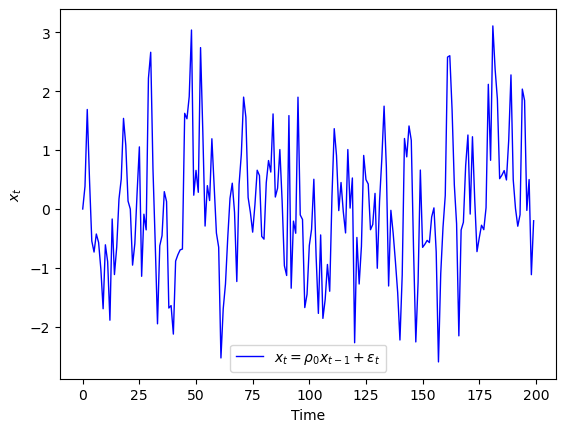

In [30]:
plt.Figure()
plt.plot(x, label=r"$x_t = \rho_0 x_{t-1} + \varepsilon_t$", color = "blue", linewidth=1)
plt.xlabel("Time")
plt.ylabel("$x_t$")
plt.legend()
plt.show()

The model generation process will be:
$$ y_t(b) = \rho y_{t-1}(b) + e_t, \qquad e_t \sim N(0,\sigma^2) $$

Where $b = (\rho, \sigma^2)$

We do not know the true parameter value $b$ so will estimate it via simulated method of moments.

Let $m$ denote the mapping from some $1 \times 1$ vector $z_t$ (either true data or model generated pseudodata) to an $n \times 1$ moment vector.

we will set $n = 3$ and construct the mean, the variance, and the first-order autocovariance using:
$$ m_3(z_t) =\begin{bmatrix}
z_t\\
(z_t-\bar{z})^2\\
(z_t-\bar{z})(z_{t-1}-\bar{z})
\end{bmatrix}$$

Thus with n > k (3>1), we have an overidentified model.

We can write the population (unconditional) moment vector for the true data using $m$ as $\mu(x) = E[m(x)]$.

The population data moments are:
$$ \mu(x) =\begin{bmatrix}
\rho_0 E[x_{t−1}] + E[\epsilon_t]\\
E[(\rho_0 x_{t−1} + \epsilon_t)^2]\\
E[(\rho_0 x_{t−1} + \epsilon_t)(\rho_0 x_{t−2} + \epsilon_{t-1})]
\end{bmatrix} = 
\begin{bmatrix}
0\\
\frac{1}{1-\rho_0^2}\\
\frac{\rho_0}{1-\rho_0^2}
\end{bmatrix}=
\begin{bmatrix}
0\\
\frac{4}{3}\\
\frac{2}{3}
\end{bmatrix}$$

The Population model moments are:
$$
\mu(y(b)) = \begin{bmatrix}
0\\
\frac{1}{1-\rho^2}\\
\frac{\rho}{1-\rho^2}
\end{bmatrix}$$

We are interested in estimating the parameter vector $b$ using SMM. The $n$ moment conditions we are going to use in SMM is given by

$$ u(x_t,b) = m(x_t) - \frac{1}{H} \sum_{h=1}^{H} m(y_t^h(b))$$

Where $H$ is the number of simulations of the model.
Then define an $nq \times 1$ vector (where $n = 3$ and $q = 1$)

$$ g(b) = E[u(x_t,b)] = E[m(x_t)] - \frac{1}{H}\sum_{h=1}^{H} E[m(y_t^h(b))] = \mu(x)-\mu(y(b))$$
**Global Identification** requires $g(b) = 0$

$$ \begin{bmatrix}
0\\
\frac{1}{1-\rho_0^2}\\
\frac{\rho_0}{1-\rho_0^2}
\end{bmatrix} =
\begin{bmatrix}
0\\
\frac{1}{1-\rho^2}\\
\frac{\rho}{1-\rho^2}
\end{bmatrix}$$

The mean does not identify $b$.

$$\nabla_b g(b_0) = - \nabla_b \mu(y(b_0)) = -
\begin{bmatrix}
0\\
\frac{2}{(1-\rho_0)^3}
\end{bmatrix}$$
